In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

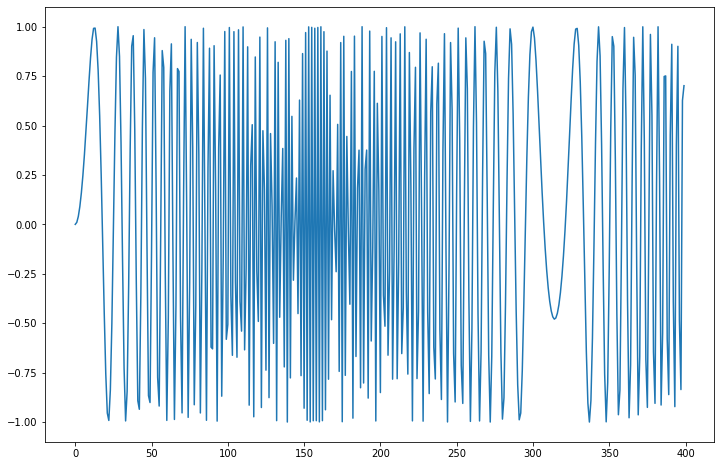

In [2]:
# make the original data
series = np.sin((0.1*np.arange(400))**2)
# plot it
plt.figure(figsize=(12,8))
plt.plot(series)
plt.show()

In [3]:
# build the datase
T = 10
D = 1
X = []
Y = []
for t in range(len(series) - T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

X = np.array(X).reshape(-1,T,1) # make it N x T x D
Y = np.array(Y).reshape(-1,1)
N = len(X)
print(f"X.shape: {X.shape}, Y.shape: {Y.shape}")

X.shape: (390, 10, 1), Y.shape: (390, 1)


In [4]:
# set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [5]:
# Define RNN
class RNN(nn.Module):
  def __init__(self, n_inputs, n_hidden, n_rnnlayers, n_outputs):
    super(RNN, self).__init__()
    self.D = n_inputs
    self.M = n_hidden
    self.K = n_outputs
    self.L = n_rnnlayers

    # note: batch_first=True
    # applies the convention that our data will be of shape:
    # (num_samples, sequence_length, num_features)
    # rather than:
    # (sequence_length, num_samples, num_features)
    self.rnn = nn.LSTM(
        input_size=self.D,
        hidden_size=self.M,
        num_layers=self.L,
        batch_first=True
    )
    self.fc = nn.Linear(self.M, self.K)

  def forward(self, X):
    # initial hidden states
    h0 = torch.zeros(self.L, X.size(0), self.M).to(device)
    c0 = torch.zeros(self.L, X.size(0), self.M).to(device)
    # get RNN unit output
    # out is of size (N, T, M)
    # 2nd return value is hidden states of each hidden layer
    # we don't need those now
    out, _ = self.rnn(X, (h0, c0))
    # we only want h(T) at the final time step
    # N x M -> N x K
    out = self.fc(out[:,-1,:])
    return out

In [7]:
# Instantiate the model
model = RNN(
    n_inputs=1,
    n_hidden=10,
    n_rnnlayers=1,
    n_outputs=1
)
model.to(device)

RNN(
  (rnn): LSTM(1, 10, batch_first=True)
  (fc): Linear(in_features=10, out_features=1, bias=True)
)

In [8]:
# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)

In [9]:
# make inputs and targets
X_train = torch.from_numpy(X[:-N//2].astype(np.float32))
y_train = torch.from_numpy(Y[:-N//2].astype(np.float32))
X_test = torch.from_numpy(X[-N//2:].astype(np.float32))
y_test = torch.from_numpy(Y[-N//2:].astype(np.float32))

In [10]:
def full_gd(model, criterion,
            optimizer, X_train,
            y_train, X_test, y_test, epochs=200):
  # stuff to store
  train_losses = np.zeros(epochs)
  test_losses = np.zeros(epochs)

  for it in range(epochs):
    # zero the parameter gradients
    optimizer.zero_grad()
    # forward pass
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    # backward and optimize
    loss.backward()
    optimizer.step()
    # save losses
    train_losses[it] = loss.item()
    # test loss
    ouputs_test = model(X_test)
    loss_test = criterion(ouputs_test, y_test)
    test_losses[it] = loss_test.item()
    if (it + 1) % 5 == 0:
      print(f"Epoch {it+1}/{epochs}, Train Loss: {loss.item():.4f}, Test Loss: {loss_test.item():.4f}")
  return train_losses, test_losses

In [11]:
# move data to GPU
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

In [12]:
train_losses, test_losses = full_gd(model,
                                    criterion,
                                    optimizer,
                                    X_train,
                                    y_train,
                                    X_test,
                                    y_test)

Epoch 5/200, Train Loss: 0.5050, Test Loss: 0.5730
Epoch 10/200, Train Loss: 0.4855, Test Loss: 0.6292
Epoch 15/200, Train Loss: 0.4478, Test Loss: 0.5415
Epoch 20/200, Train Loss: 0.3805, Test Loss: 0.5568
Epoch 25/200, Train Loss: 0.2965, Test Loss: 0.5021
Epoch 30/200, Train Loss: 0.2049, Test Loss: 0.3693
Epoch 35/200, Train Loss: 0.1045, Test Loss: 0.2820
Epoch 40/200, Train Loss: 0.0826, Test Loss: 0.2614
Epoch 45/200, Train Loss: 0.0487, Test Loss: 0.2165
Epoch 50/200, Train Loss: 0.0326, Test Loss: 0.2107
Epoch 55/200, Train Loss: 0.0224, Test Loss: 0.2043
Epoch 60/200, Train Loss: 0.0153, Test Loss: 0.1994
Epoch 65/200, Train Loss: 0.0117, Test Loss: 0.1960
Epoch 70/200, Train Loss: 0.0084, Test Loss: 0.1965
Epoch 75/200, Train Loss: 0.0070, Test Loss: 0.2030
Epoch 80/200, Train Loss: 0.0057, Test Loss: 0.2010
Epoch 85/200, Train Loss: 0.0049, Test Loss: 0.1993
Epoch 90/200, Train Loss: 0.0038, Test Loss: 0.1998
Epoch 95/200, Train Loss: 0.0033, Test Loss: 0.1957
Epoch 100/200

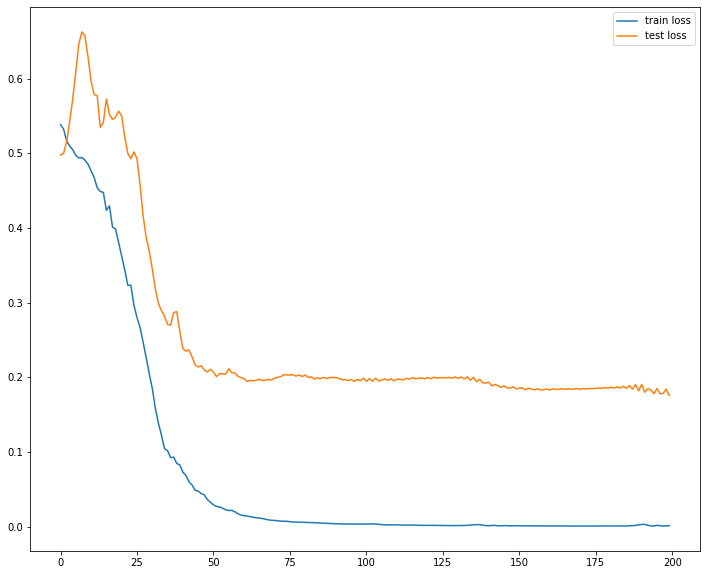

In [13]:
# plot the train loss and test loss per iteration
plt.figure(figsize=(12,10))
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

In [14]:
# "wrong" one-step forecast using true targets
validation_target = Y[-N//2:]
validation_predictions = []

# index of first validation input
i = 0
while len(validation_predictions) < len(validation_target):
  input_ = X_test[i].reshape(1,T,1)
  p = model(input_)[0,0].item() # 1x1 arry -> scalar
  i += 1
  # update the predictions list
  validation_predictions.append(p)

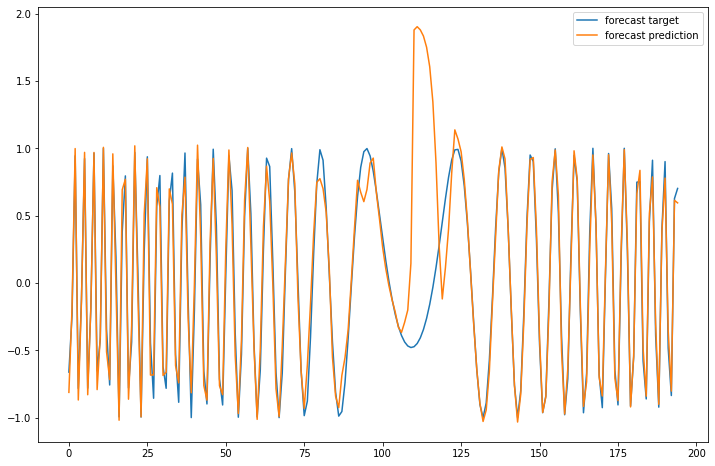

In [15]:
plt.figure(figsize=(12,8))
plt.plot(validation_target, label="forecast target")
plt.plot(validation_predictions, label="forecast prediction")
plt.legend()

In [16]:
# Multi-step forecast
# Forecast future values (use only self-predictions for making future predictions)
validation_target = Y[-N//2:]
validation_predictions = []
# last train input
# last_x = torch.from_numpy(X[-N//2]) # 1-D array of length T
# last_x = torch.from_numpy(X[-N//2].astype(np.float32))
last_x = X_test[0].view(T)
while len(validation_predictions) < len(validation_target):
  input_ = last_x.reshape(1,T,1)
  p = model(input_) # [0,0] 1x1 array -> scalar
  # update the predictions list
  validation_predictions.append(p[0,0].item())
  # make the new input
  last_x = torch.cat((last_x[1:], p[0]))

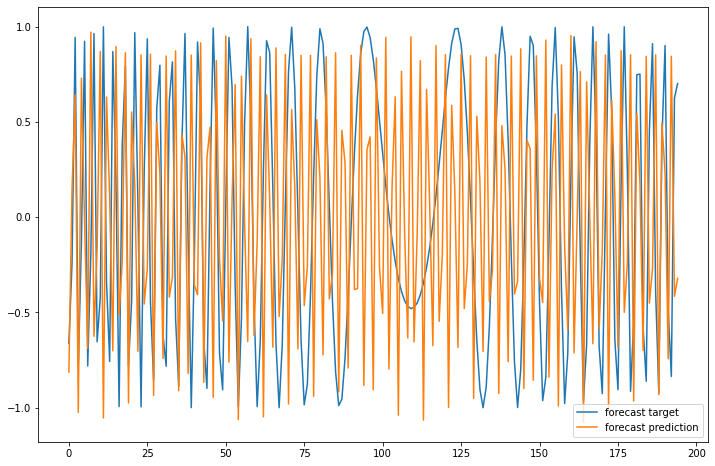

In [17]:
plt.figure(figsize=(12,8))
plt.plot(validation_target, label="forecast target")
plt.plot(validation_predictions, label="forecast prediction")
plt.legend()